In [2]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2

import scipy.signal as signal
from obspy.signal import filter as obsfilt
import glob


## Unfiltered

In [2]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

init = 11
final= 16

time_subsample = 10
full_dat = np.zeros((5000,(12000//time_subsample)*(final-init)))

k = 0
for i in np.arange(init,final):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    
working_dat = full_dat/np.std(full_dat)


In [3]:
# path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
# file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"
# # file2 = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231214Z.h5"

# f = h5py.File(path+file, 'r')
# data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
# timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
# f.close()

In [4]:
# time_subsample = 1
# full_dat = np.#data[7500:12500,::time_subsample]

# for i in np.arange(12,16):
#     file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
#     f = h5py.File(path+file, 'r')
#     data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
# #     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
#     f.close()
    
#     full_dat = np.hstack((full_dat,data[7500:12500,::time_subsample]))

In [5]:
# # np.arange(11,31).shape

# n = 1.4682
# L = 51.04762
# full_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*full_dat[:,::10]

# # EDIT!!!

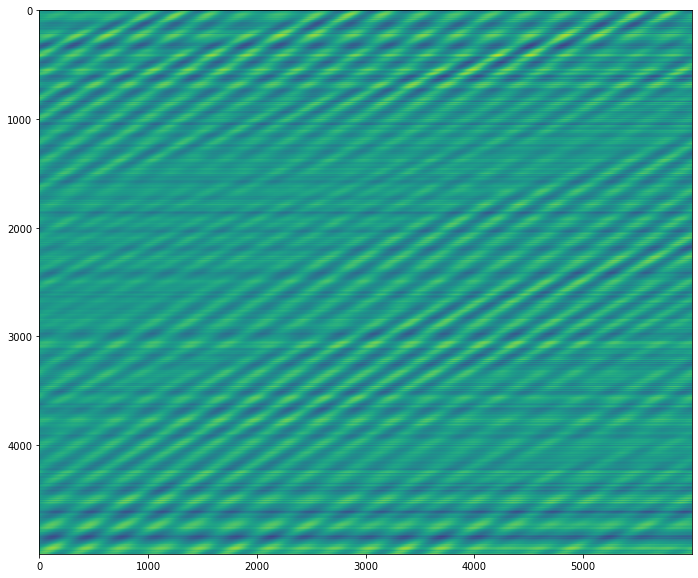

In [6]:
plt.figure(figsize=(12,10))
plt.imshow(full_dat)
plt.show()

In [7]:
dt=1. #/200
# working_dat = full_dat[:,::10]/np.std(full_dat)#*10**6
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])#*2.0419047

# time = dt*np.arange(working_dat.shape[0])

In [8]:
xs.shape

(5000,)

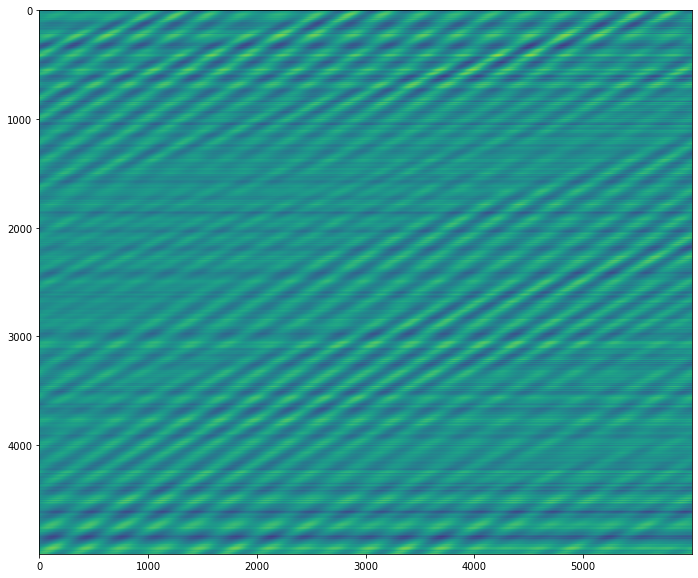

In [9]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0], vmin=-5.,vmax=5.)
plt.show()

In [10]:
# library_functions = [lambda x: x, lambda x: x * x]
# library_function_names = [lambda x: x, lambda x: x + x]
# pde_lib = ps.PDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
#     derivative_order=4,
#     spatial_grid=xs,
#     include_bias=True,
#     is_uniform=True,
# #     periodic=True
# )

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

X, T = np.meshgrid(xs, np.arange(working_dat.shape[1]))
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

### Dataset 1

In [11]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=300)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7f291aa564f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=300, threshold=1.0))

In [12]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -83.073 x0_111


In [13]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=300)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7f291aa564f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=300, threshold=0.01))

In [14]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.024 x0_1 + -0.052 x0_11 + -43.875 x0_111 + 0.013 x0x0_1 + 0.038 x0x0_111


In [15]:
thresh = 0.005
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=300)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7f291aa564f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=300, threshold=0.005))

In [16]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.005
(x0)' = 0.024 x0_1 + -0.052 x0_11 + -43.875 x0_111 + 0.013 x0x0_1 + 0.038 x0x0_111


### Dataset 2 (weak formulation)

In [16]:
time_subsample = 10
full_dat = np.zeros((5000,6000))

k = 0
for i in np.arange(21,26):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    


In [17]:
# n = 1.4682
# L = 51.04762
# full_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*full_dat


In [18]:
dt=1. #/200
working_dat = full_dat/np.std(full_dat)#*10**6
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])#*2.0419047

# time = dt*np.arange(working_dat.shape[0])

In [19]:
np.amax(working_dat)

4.3295561489243255

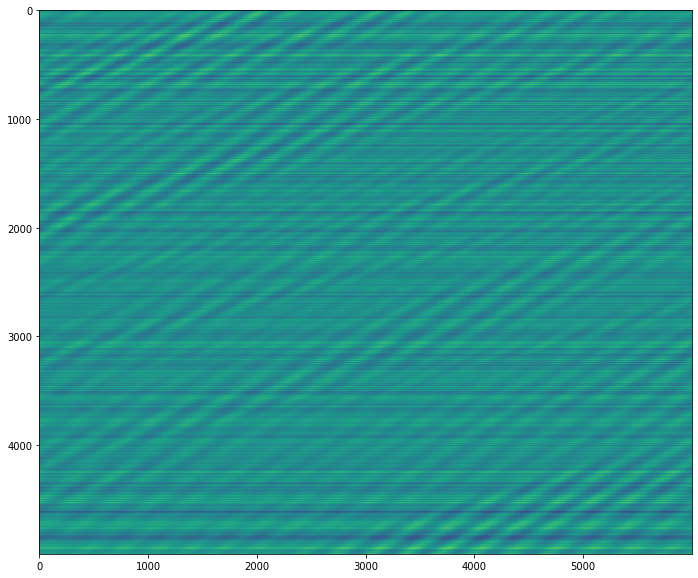

In [20]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0], vmin=-5.,vmax=5.)
plt.show()

In [21]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

X, T = np.meshgrid(xs, np.arange(working_dat.shape[1]))
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

In [22]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe3daacaa90>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=1.0))

In [23]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -64.853 x0_111


In [24]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe3daacaa90>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.01))

In [25]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = -0.023 x0_11 + -64.836 x0_111


In [26]:
thresh = 0.005
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe3daacaa90>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.005))

In [27]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.005
(x0)' = -64.853 x0_111


## Gaussian Filtered



In [28]:
file_list = glob.glob("/home/ldoyle/notebooks/rad_10_smooth_data/*")

In [29]:
# n = 1.4682
# L = 51.04762
working_dat = np.zeros((5000,6000))
b=0
for q in np.arange(5):
#     if b==0:
#         working_dat = np.load(file_list[q])
#         b=1
#     else:
#         working_dat = np.hstack((working_dat, np.load(file_list[q])))
    working_dat[:,q*(1200):(q+1)*1200] = np.load(file_list[q])[:,::10]
        
# working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

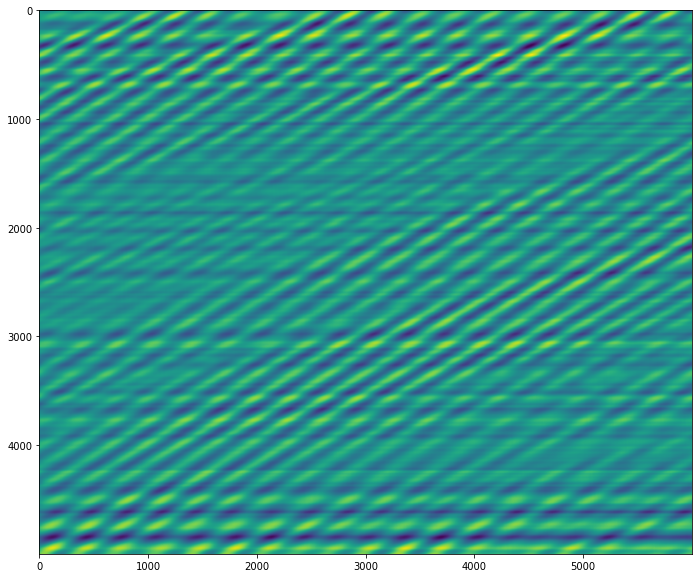

In [30]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0])
plt.show()

In [31]:
xs = np.arange(working_dat.shape[0])
print(xs.shape)

(5000,)


In [32]:
# library_functions = [lambda x: x, lambda x: x * x]
# library_function_names = [lambda x: x, lambda x: x + x]
# pde_lib = ps.PDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
#     derivative_order=4,
#     spatial_grid=xs,
#     include_bias=True,
#     is_uniform=True,
# #     periodic=True
# )

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

X, T = np.meshgrid(xs, np.arange(working_dat.shape[1]))
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

### Dataset 1

In [33]:
thresh = 2.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe357fc5b20>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=2.0))

In [34]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 2.0
(x0)' = -97.556 x0_111 + 2.345 x0x0x0_111


In [35]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe357fc5b20>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=1.0))

In [36]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -97.658 x0_111 + -1.625 x0x0_111 + 2.193 x0x0x0_111


### Dataset 2

In [37]:
# n = 1.4682
# L = 51.04762
working_dat = np.zeros((5000,6000))
b=0
for q in np.arange(10,15):

    working_dat[:,b*(1200):(b+1)*1200] = np.load(file_list[q])[:,::10]
    b+=1
# working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

In [38]:
thresh = 2.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe357fc5b20>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=2.0))

In [39]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 2.0
(x0)' = -94.222 x0_111


In [40]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe357fc5b20>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=1.0))

In [41]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -94.222 x0_111


In [42]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe357fc5b20>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=50))

In [43]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.452 x0_11 + -97.866 x0_111 + -0.979 x0x0_111 + 0.211 x0x0x0_111


## Drift Removal Load

In [44]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_11.npy")[:,::10]
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])

In [45]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

X, T = np.meshgrid(xs, np.arange(working_dat.shape[1]))
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

In [46]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe3dfa6f130>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=1.0))

In [47]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = 1.431 x0_11 + -946.749 x0_111


In [48]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe3dfa6f130>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=50))

In [49]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 1.365 x0_11 + -946.218 x0_111 + -1.003 x0x0_111 + 0.227 x0x0x0_111


In [50]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe3dfa6f130>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.01))

In [51]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.042 x0_1 + 1.444 x0_11 + -897.670 x0_111 + 0.020 x0x0_1 + -0.044 x0x0x0_1 + -0.030 x0x0x0_11 + -0.016 x0x0_111 + 0.075 x0x0x0_111


### Dataset 2

In [52]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_21.npy")[:,::10]
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])

In [53]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe3dfa6f130>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=1.0))

In [54]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -967.950 x0_111 + -2.086 x0x0_111 + -1.707 x0x0x0_111


In [55]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe3dfa6f130>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=50))

In [56]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = -0.250 x0_1 + -0.344 x0_11 + -1389.909 x0_111 + 0.134 x0x0x0_11 + -2.093 x0x0_111 + -1.729 x0x0x0_111


In [57]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7fe3dfa6f130>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.01))

In [58]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = -0.255 x0_1 + -0.328 x0_11 + -1398.456 x0_111 + 0.024 x0x0_1 + -0.005 x0x0x0_1 + 0.133 x0x0x0_11 + -1.046 x0x0_111 + -1.964 x0x0x0_111


## Multifilt

In [6]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/smoothed_decimated_normalized_5_min_start_11.npy")
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])
dt = 1

In [4]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

X, T = np.meshgrid(xs, np.arange(working_dat.shape[1]))
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

### Dataset 1

In [20]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7f291afd91c0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1.0))

In [21]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -983.180 x0_111


In [7]:
thresh = 0.5
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7f10c144ee20>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.5))

In [8]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.5
(x0)' = -946.229 x0_111 + -1.711 x0x0_111 + 7.090 x0x0x0_111


In [22]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7f291afd91c0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [23]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = -0.037 x0_11 + -982.044 x0_111 + -1.492 x0x0_111 + -0.858 x0x0x0_111


In [24]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7f291afd91c0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [25]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.058 x0_1 + -0.336 x0_11 + -917.988 x0_111 + -0.066 x0x0x0_1 + 0.055 x0x0x0_11 + -1.311 x0x0_111 + 0.736 x0x0x0_111


### drift removal

In [41]:
A_channel = np.hstack((np.arange(full_dat.shape[1]).reshape((-1,1)),np.ones(full_dat.shape[1]).reshape((-1,1))))
coeffs = np.zeros((full_dat.shape[0],2))
for channel in range(full_dat.shape[0]):
    coeffs[channel,:] = np.linalg.lstsq(A_channel, full_dat[channel,:], rcond=None)[0]
    

In [42]:
drift_removal = np.zeros(full_dat.shape)
for channel in range(full_dat.shape[0]):
    drift_removal[channel,:] = full_dat[channel,:]-(coeffs[channel,0]*A_channel[:,0] + coeffs[channel,1])

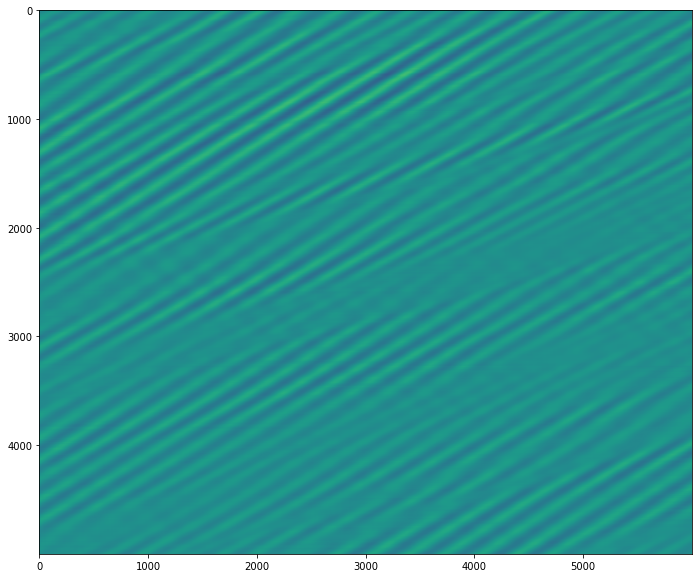

In [43]:
plt.figure(figsize=(12,10))
plt.imshow(drift_removal[:,:]*10**6, vmin=-5.,vmax=5.)
plt.show()

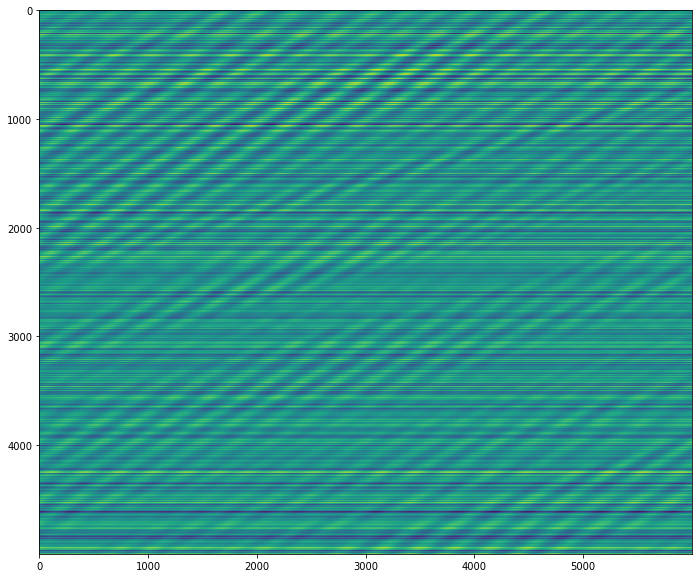

In [44]:
plt.figure(figsize=(12,10))
plt.imshow(full_dat[:,:]*10**6, vmin=-5.,vmax=5.)
plt.show()

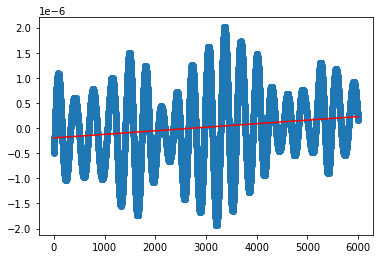

In [45]:
plt.figure()
plt.scatter(A_channel[:,0],full_dat[587,:])
plt.plot(A_channel[:,0],coeffs[587,0]*A_channel[:,0] + coeffs[587,1],c='r')

plt.show()

In [46]:
dt=1. #/200
working_dat = drift_removal[:,:]*10**6
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])#*2.0419047

# time = dt*np.arange(working_dat.shape[0])

In [47]:
xs.shape

(5000,)

In [48]:
# library_functions = [lambda x: x, lambda x: x * x]
# library_function_names = [lambda x: x, lambda x: x + x]
# pde_lib = ps.PDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
#     derivative_order=4,
#     spatial_grid=xs,
#     include_bias=True,
#     is_uniform=True,
# #     periodic=True
# )

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

X, T = np.meshgrid(xs, np.arange(working_dat.shape[1]))
XT = np.asarray([X, T]).T

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

In [57]:
thresh = 0.3
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.weak_pde_library.WeakPDELibrary object at 0x7f109c94e250>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.3))

In [58]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.3
(x0)' = -936.212 x0_111 + -0.339 x0x0x0_111


In [58]:
thresh = 0.05
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff167a316d0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.05))

In [59]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.235 x0_1 + 0.107 x0_111


In [54]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7ff167a316d0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=0.01))

In [55]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.265 x0_1 + 0.123 x0_111 + -0.070 x0x0x0_1 + -0.035 x0x0x0_111
